# Mouvement brownien

Premièrement théorisé par Einstein en 1905, le mouvement brownien est le mouvement aléatoire de particules microscopiques en suspension dans un fluide (liquide ou gaz). Causé par les collisions incessantes entre les particules en suspension et les molécules du fluide environnant, ce phénomène a été pour la première fois décrit mathématique par Langevin en 1908. On se propose ici, à travers diverses simulations numériques, d'illustrer ce phénomène physique fondamental.

## Equation de Langevin
L'équation de Langevin décrit le mouvement d'une particule soumise à des forces aléatoires. Elle s'écrit sous la forme suivante :
$$m \frac{d^2 x(t)}{dt^2} = -\gamma \frac{dx(t)}{dt} + f(x) + \eta(t)$$
où :
- $m$ est la masse de la particule _(en kg)_
- $\gamma$ est le coefficient de friction _(en kg/s)_
- $f(x)$ est une force externe appliquée à la particule (et ne dépendant pas du temps) _(en N)_
- $\eta(t)$ est une force aléatoire représentant les collisions entre particules, dont l'intensité dependant essentiellement de la température. _(en N)_

## Cas de sur-amortissement

Prenons premièrement le cas de sur-amortissement, où l'on peut négliger le terme d'inertie. L'équation de Langevin se simplifie alors en :
$$\gamma \frac{dx(t)}{dt} = f(x) + \eta(t)$$

On peut également la réécrire sous la forme d'une équation différentielle stochastique (EDS) :
$$dx(t) = \frac{f(x)}{\gamma} dt + \sqrt{2Ddt} R(t)$$
avec $D$ le coefficient de diffusion _en m²/s_, et $R(t)$ un bruit blanc gaussien de moyenne nulle et de variance unitaire.



### Cas sans force extérieure
Commençons par simuler le cas où il n'y a pas de force extérieure, c'est à dire $f(x) = 0$. Prenons comme premier exemple le cas où $D=1$ et $\gamma=1$. Nous allons simuler la trajectoire d'une particule soumise à ce mouvement brownien sur une durée de 1000 secondes, avec un pas de temps de 0.1 seconde.

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from free_particle import euler_maruyama

In [106]:
# Paramètres de la simulation
step = 10000 # Nombre de pas de temps
dt = 0.01 # Pas de temps
gamma = 1.0 # Coefficient de friction
D = 1.0 # Coefficient de diffusion
x0 = 0.0 # Position initiale

# Simulation du mouvement brownien
T = step*dt # Temps total de simulation
x = euler_maruyama(D, gamma, T, dt)
t = np.arange(0, T, dt)

# Simulation de plusieurs random-walk pour faire la moyenne sur plein
n_walks = 1_000
x_0 = np.zeros((n_walks,))
x_walks = euler_maruyama(D, gamma, T, dt, x0=x_0)

In [107]:
nb = 5000
print(f"Moyenne sur {n_walks} random-walks : {x_walks[nb].mean()}")
print(f"Variance sur {n_walks} random-walks : {x_walks[nb].var()}")

Moyenne sur 1000 random-walks : -0.050981256563830867
Variance sur 1000 random-walks : 92.17762345687193


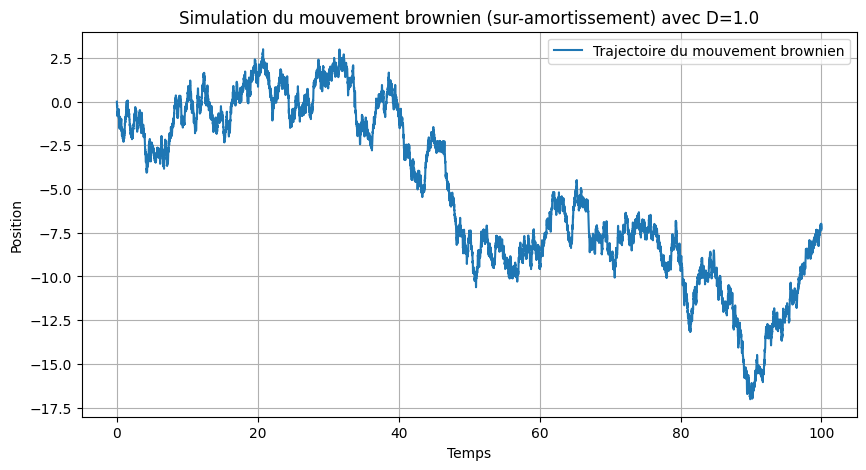

In [108]:
# Tracé de la trajectoire
plt.figure(figsize=(10, 5))
plt.plot(t, x, label='Trajectoire du mouvement brownien')
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('Simulation du mouvement brownien (sur-amortissement) avec D={}'.format(D))
plt.legend()
plt.grid()
plt.show()

In [109]:
import ipywidgets as widgets

def show_stats(nb):
    plt.figure(figsize=(8, 4))
    plt.hist(x_walks[nb], bins=80, density=True)
    plt.xlabel("Position")
    plt.ylabel("Densite de probabilite")
    plt.title("Distribution des positions sur {} random-walks".format(n_walks))
    plt.show()

nb_slider = widgets.IntSlider(
    value=5000,
    min=0,
    max=x_walks.shape[0] - 1,
    step=1,
    description="nb",
)

widgets.interact(show_stats, nb=nb_slider)

interactive(children=(IntSlider(value=5000, description='nb', max=9999), Output()), _dom_classes=('widget-inte…

<function __main__.show_stats(nb)>

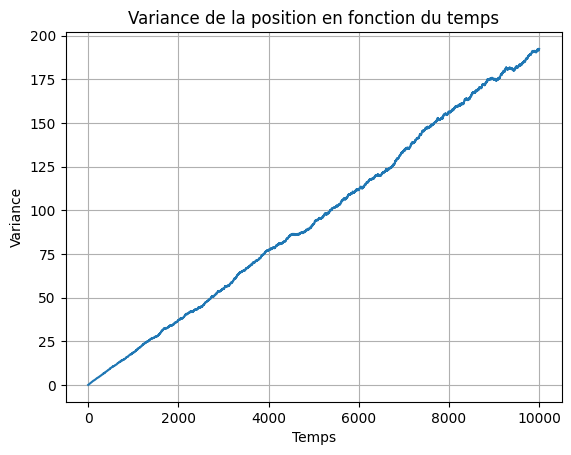

In [110]:
vars = x_walks.var(axis=1)
plt.plot(vars)
plt.xlabel("Temps")
plt.ylabel("Variance")
plt.title("Variance de la position en fonction du temps")
plt.grid()
plt.show()

### Influence du coefficient D

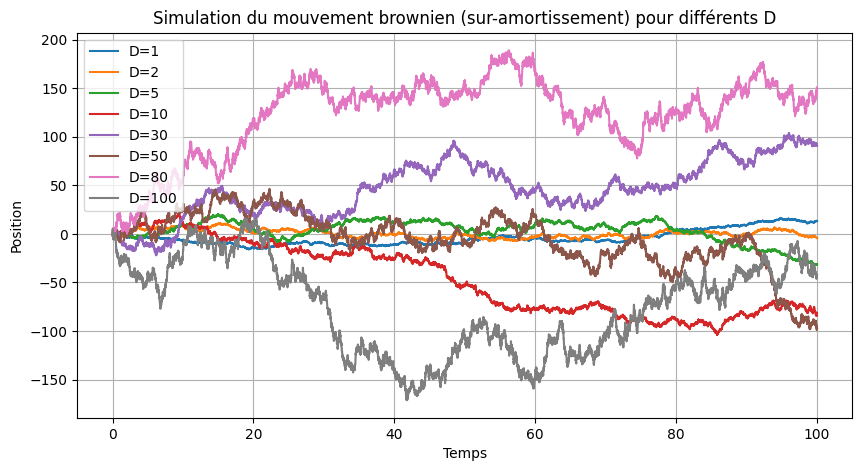

In [111]:
# Avec différents D

D = [1,2,5,10, 30, 50, 80, 100,]
x = np.zeros((len(D), step, n_walks))
x0 = np.zeros((n_walks,))
for i, d in enumerate(D):
    x[i] = euler_maruyama(d, gamma, T, dt, x0=x0)

# Tracé de la trajectoire
plt.figure(figsize=(10, 5))
for i, d in enumerate(D):
    plt.plot(t, x[i, :, 0], label='D={}'.format(d))
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('Simulation du mouvement brownien (sur-amortissement) pour différents D')
plt.legend()
plt.grid()
plt.show()

On constate que l'augmentation de D rend la trajectoire beaucoup plus étendue confirmant notre intuition que D est un coefficient de diffusion. En effet, plus D est grand, plus la particule subit des forces aléatoires importantes, ce qui se traduit par une trajectoire plus erratique et "de grande variance".

In [112]:
x.shape
x.mean(2).shape

(8, 10000)

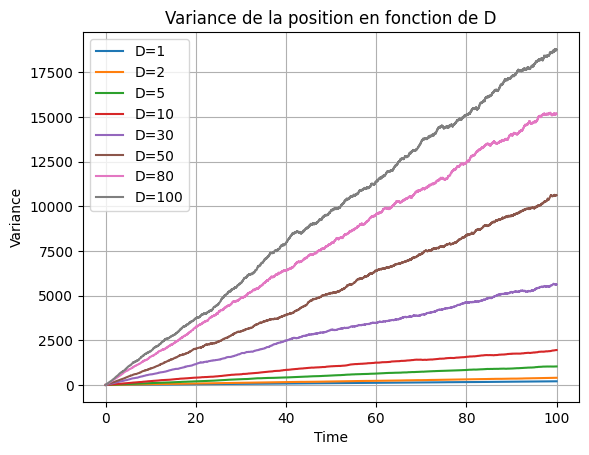

In [113]:
plt.plot(t, x.var(2).T, label=[f"D={d}" for d in D])
plt.xlabel("Time")
plt.ylabel("Variance")
plt.title("Variance de la position en fonction de D")
plt.grid()
plt.legend()
plt.show()

La variance au cours du temps augmente de manière linéaire, et plus D est grand, plus la pente de cette augmentation est élevée. 

### Ajout d'une force extérieure
#### Potentiel harmonique

Ajoutons maintenant une force extérieure dérivant d'un potentiel qu'on choisira comme harmonique. Le potentiel harmonique est défini par :
$$V(x) = \frac{1}{2} k x^2$$
où $k$ est la constante de raideur du potentiel. La force correspondante est donnée par :
$$f(x) = -\frac{dV}{dx} = -kx$$



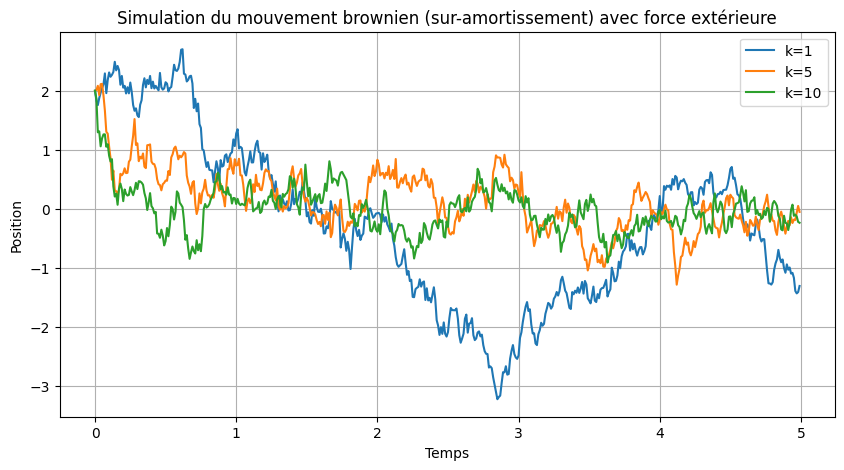

In [114]:
## Paramètres changés pour cette résolution
n_walks = 1000
k_liste = [1, 5, 10]
D = 1 # Coefficient de diffusion
step = 500 # Nombre de pas de temps
T = step*dt # Temps total de simulation
y = np.zeros((len(k_liste), step, n_walks,))
x_0 = np.ones((n_walks,)) * 2
t = np.arange(0, T, dt)

# Simulation du mouvement brownien avec force extérieure
for i, k in enumerate(k_liste):
    y[i, :, :] = euler_maruyama(D, gamma, T, dt, f=lambda x: -k*x, x0=x_0)


walk_nb = 500
# Tracé de la trajectoire
plt.figure(figsize=(10, 5))
for i, k in enumerate(k_liste):
    plt.plot(t, y[i, :, walk_nb], label='k={}'.format(k))

plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('Simulation du mouvement brownien (sur-amortissement) avec force extérieure')
plt.legend()
plt.grid()
plt.show()


In [115]:
def show_stats(nb, k=0):
    plt.figure(figsize=(8, 4))
    plt.hist(y[k, nb], bins=80, density=True)
    plt.xlabel("Position")
    plt.ylabel("Densite de probabilite")
    plt.title("Distribution des positions sur {} random-walks".format(n_walks))
    plt.show()

nb_slider = widgets.IntSlider(
    value=5000,
    min=0,
    max=y.shape[1] - 1,
    step=1,
    description="nb",
)

widgets.interact(show_stats, nb=nb_slider, k=widgets.IntSlider(value=0, min=0, max=len(k_liste)-1, step=1, description="k"))

interactive(children=(IntSlider(value=499, description='nb', max=499), IntSlider(value=0, description='k', max…

<function __main__.show_stats(nb, k=0)>

In [116]:
y.shape

(3, 500, 1000)

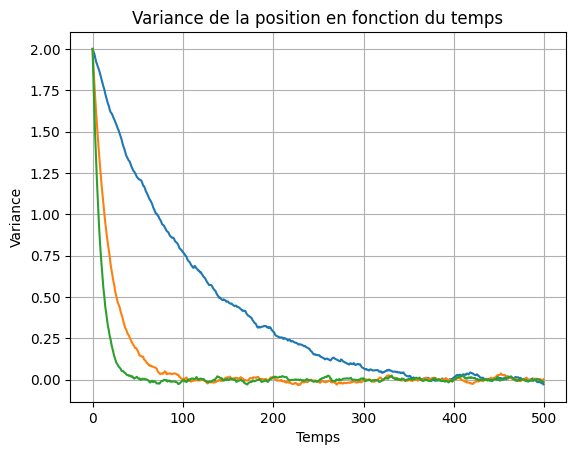

In [117]:
vars = y.mean(axis=2).T
plt.plot(vars)
plt.xlabel("Temps")
plt.ylabel("Variance")
plt.title("Variance de la position en fonction du temps")
plt.grid()
plt.show()

In [118]:
from scipy.optimize import curve_fit

A=2.01641577477104, tau=1.0800962652842108, b=-0.03699959747396814


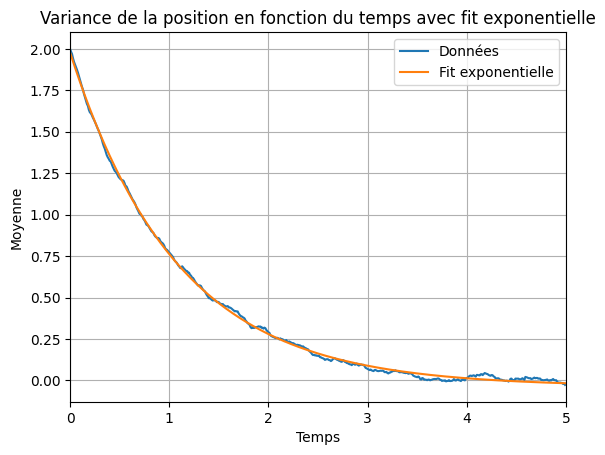

In [119]:
def exp_law(t, A, tau, b):
    return A * (np.exp(-t/tau)) + b
data = vars[:, 0]
popt, pcov = curve_fit(exp_law, t, data)
A, tau, b = popt
print(f"A={A}, tau={tau}, b={b}")

plt.plot(t, data, label="Données")
plt.plot(t, exp_law(t, *popt), label="Fit exponentielle")
plt.xlabel("Temps")
plt.ylabel("Moyenne")
plt.title("Variance de la position en fonction du temps avec fit exponentielle")
plt.legend()
plt.grid()
plt.xlim(0, 5)
plt.show()

Temps caractéristique de relaxation:
Le temps de relaxation en excluant la partie stochastique est donné par :
$$\tau = \frac{\gamma}{k}$$
On vérifie bien ci dessus la correspondance (pour des marche moyenné) entre la théorie et la simulation numérique.

#### Potentiel de double puits
Prenons maintenant un potentiel de double puits, défini par :
$$V(x) = ax^4 - bx^2$$
où $a$ et $b$ sont des constantes positives. La force correspondante est donnée par :
$$f(x) = -\frac{dV}{dx} = -4ax^3 + 2bx$$

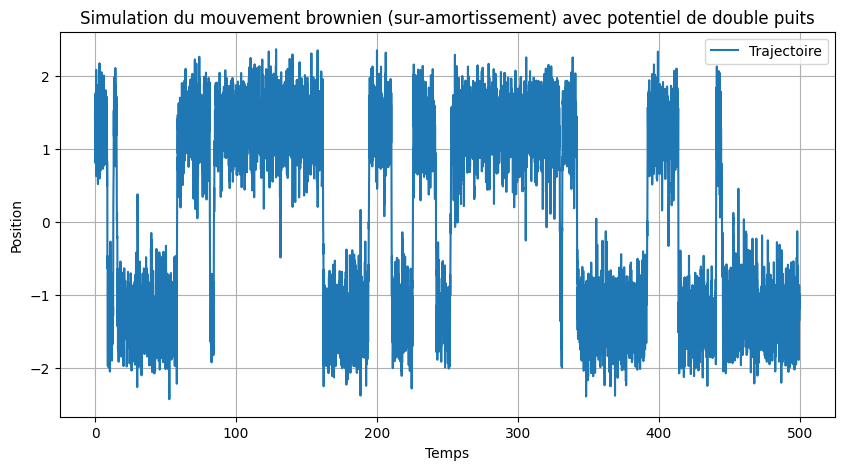

In [120]:
### Paramètres changés pour cette résolution

n_walks = 10000
a = 1.0
b = 4
D = 1.0 # Coefficient de diffusion
step = 10000 # Nombre de pas de temps
dt = 0.05 # Pas de temps
T = step*dt # Temps total de simulation
t = np.arange(0, T, dt)
x_0 = np.ones((n_walks,)) * 1.5 # Simulation du mouvement brownien avec force extérieure
y = euler_maruyama(D, gamma, T, dt, f=lambda x: -4*a*x**3 + 2*b*x, x0=x_0)

# Tracé de la trajectoire
plt.figure(figsize=(10, 5))
plt.plot(t, y[:, 0], label='Trajectoire')
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('Simulation du mouvement brownien (sur-amortissement) avec potentiel de double puits')
plt.legend()
plt.grid()
plt.show()

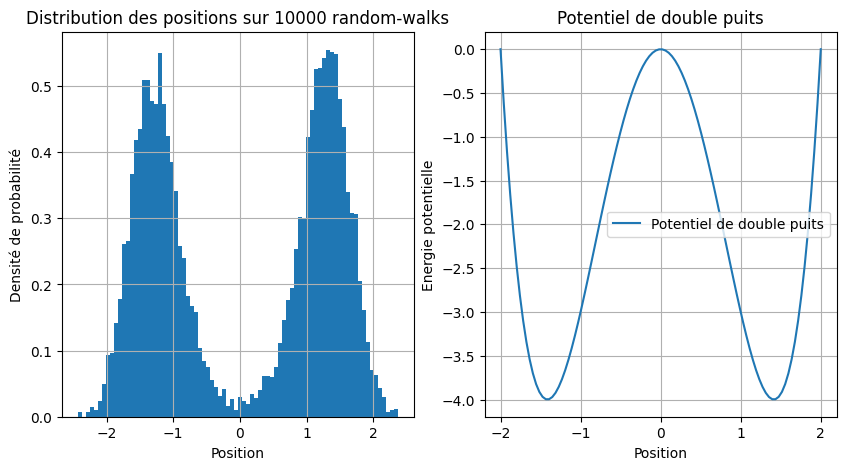

In [121]:
# Bin des positions (ordonnée gauche) en même temps que le potentiel (ordonnée droite)

x = np.linspace(-2, 2, 100)
V = a*x**4 - b*x**2
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(y[:, 0], bins=80, density=True)
plt.xlabel("Position")
plt.ylabel("Densité de probabilité")
plt.title("Distribution des positions sur {} random-walks".format(n_walks))
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(x, V, label='Potentiel de double puits')

plt.xlabel('Position')
plt.ylabel('Energie potentielle')
plt.title('Potentiel de double puits')
plt.legend()
plt.grid()
plt.show()

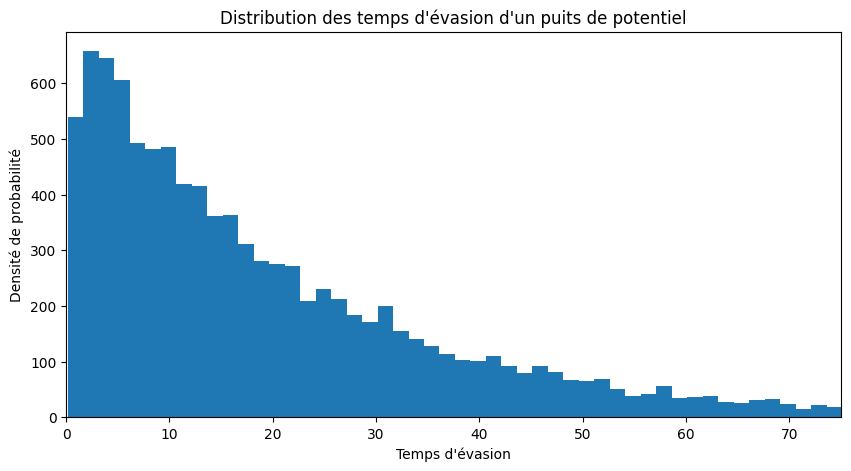

In [122]:
# Temps moyen pour s'échapper du puits de potentiel
escape_times = np.zeros((n_walks,))
for i in range(n_walks):
    if np.argmax(y[:, i]  < -1.0) == 0:
        escape_times[i] = T
    else:
        escape_times[i] = np.argmax(y[:, i]  < -1.0) * dt
plt.figure(figsize=(10, 5))
plt.hist(escape_times, bins=120)
plt.xlabel("Temps d'évasion")
plt.ylabel("Densité de probabilité")
plt.xlim(0, 75)
plt.title("Distribution des temps d'évasion d'un puits de potentiel")
plt.show()


In [123]:
escape_times

array([ 9.  , 25.25, 19.05, ...,  9.6 ,  5.6 ,  4.2 ], shape=(10000,))

In [124]:
escape_times.mean()

np.float64(21.1921)

**Relation d'Einstein entre $D$, $\gamma$ et la température $T$**: $$D = \frac{k_B T}{\gamma}$$

In [139]:
# Pour plusieurs valeurs de D (et donc de kbT), on fait plusieurs simulations de n_walks random-walks

D = [1, 2, 4, 5, 7.5, 10]
gamma = 1

escape_times_mean = np.zeros(len(D))
for i, d in enumerate(D):
    y = euler_maruyama(d, gamma, T, dt, f=lambda x: -4*a*x**3 + 2*b*x, x0=x_0)
    escape_times = np.zeros((n_walks,))
    for j in range(n_walks):
        if np.argmax(y[:, j]  < -1.0) == 0:
            escape_times[j] = T
        else:
            escape_times[j] = np.argmax(y[:, j]  < -1.0) * dt
    escape_times_mean[i] = escape_times.mean()

C:\Users\Maj\AppData\Local\Temp\ipykernel_17132\1394023650.py:8: RuntimeWarning: overflow encountered in power
  y = euler_maruyama(d, gamma, T, dt, f=lambda x: -4*a*x**3 + 2*b*x, x0=x_0)
C:\Users\Maj\AppData\Local\Temp\ipykernel_17132\1394023650.py:8: RuntimeWarning: invalid value encountered in add
  y = euler_maruyama(d, gamma, T, dt, f=lambda x: -4*a*x**3 + 2*b*x, x0=x_0)
C:\Users\Maj\AppData\Local\Temp\ipykernel_17132\1394023650.py:8: RuntimeWarning: overflow encountered in multiply
  y = euler_maruyama(d, gamma, T, dt, f=lambda x: -4*a*x**3 + 2*b*x, x0=x_0)


A=3.910102793893056, b=0.7010983494794287


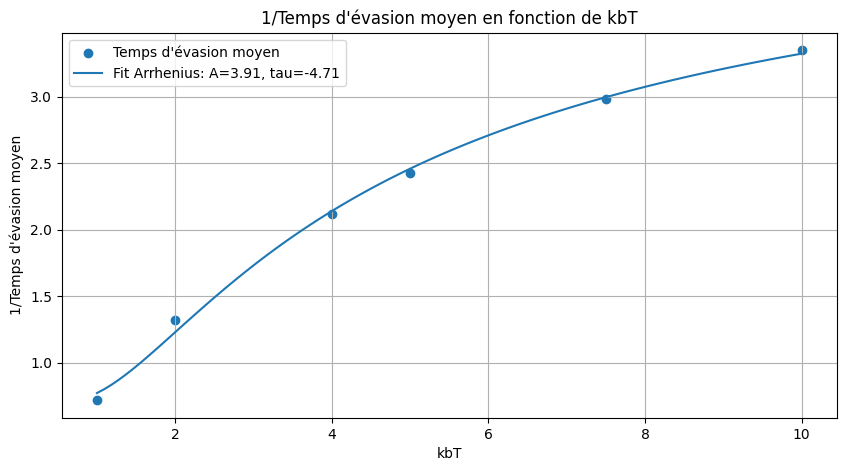

In [159]:

# Graphe des espaces_times_mean en fonction de kbT
kbT = np.array(D) * gamma
plt.figure(figsize=(10, 5))
plt.scatter(kbT, 1/escape_times_mean, label='Temps d\'évasion moyen')

#Fit avec la loi d'Arrhenius
def arrhenius_law(kbt, A,b):
    return A * np.exp(-4/kbt) + b
popt, pcov = curve_fit(arrhenius_law, kbT, 1/escape_times_mean, p0=[1, 0])
A, b= popt
print(f"A={A}, b={b}")
X = np.linspace(1, 10, 100)
plt.plot(X, arrhenius_law(X, *popt), label=f"Fit Arrhenius: A={A:.2f}, tau={tau:.2f}")

plt.xlabel("kbT")
plt.ylabel("1/Temps d'évasion moyen")
plt.title("1/Temps d'évasion moyen en fonction de kbT")
plt.legend()
plt.grid()
plt.show()

In [127]:
# Les 3 graphes avec différentes valeurs de b

b_liste = [1.5, 2.5, 3.5]
y = np.zeros((len(b_liste), step, n_walks,))
for i, b in enumerate(b_liste):
    y[i] = euler_maruyama(D, gamma, T, dt, f=lambda x: -4*a*x**3 + 2*b*x, x0=x_0)
plt.figure(figsize=(15, 5))
for i, b in enumerate(b_liste):
    plt.subplot(1, len(b_liste), i+1)
    plt.hist(y[i, :, 0], bins=80, density=True)
    plt.xlabel("Position")
    plt.ylabel("Densité de probabilité")
    plt.title("Distribution des positions pour b={}".format(b))
    plt.grid()
plt.show()

TypeError: can't multiply sequence by non-int of type 'float'

On observe comme attendu que plus le puits de potentiel est profond (plus b est grand), plus la particule a tendance à rester dans les puits, ce qui se traduit par une distribution des positions plus concentrée autour des minima du potentiel. En revanche, pour des valeurs de b plus petites, la particule peut plus facilement surmonter les barrières de potentiel, ce qui conduit à une distribution des positions plus étalée.

## Cas deux dimensions


### Cas avec inertie
Prenons maintenant le cas où l'on ne peut pas négliger le terme d'inertie dans l'équation de Langevin. L'équation complète s'écrit alors :
$$dv = -\frac{\gamma}{m} v dt + \frac{f(x)}{m} dt + \frac{\gamma}{m}\sqrt{2Ddt} R(t)$$
avec $dx = v dt$.